In [473]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cross_validation

sns.set()

# Make charts a bit bolder
#sns.set_context("talk")

%matplotlib inline

# Default figure size
sns.set(rc={"figure.figsize": (12, 6)})

# This actually makes autocomplete WAY faster ...
%config Completer.use_jedi = False

# Show only 2 decimals for floating point numbers
pd.options.display.float_format = "{:.2f}".format

sns.set_style('whitegrid')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [474]:
data = pd.read_csv('./crypto-markets.csv')

In [475]:
data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32


In [476]:
data.shape

(679183, 13)

In [477]:
# Convert date to real date
data['date'] = pd.to_datetime(data['date'])

Here are the descriptions for some of the columns that I wasn't really sure about:

+ volume  - Transactions volume 
+ market  - Market Cap
+ ranknow - Currency rank
+ spread  - Spread between high and low

Also, one thing I noticed -- market caps are quite huge. For ease of observing, let's introduce a new column - market_billion, which will represent currencies Market Cap in billion

In [478]:
data['market_billion'] = data['market'] / 1000000000
data['volume_billion'] = data['volume'] / 1000000000

In [479]:
# Some common filters that we might be using

is_bitcoin = data['symbol'] == 'BTC'
is_etherum = data['symbol'] == 'ETH'
is_ripple  = data['symbol'] == 'XRP'

# Pull out a part of dataset that only has the most interesting currencies
data_top_currencies = data[is_bitcoin | is_etherum | is_ripple]


Now, let's chart out Top currencies according to latest reported Market Cap

In [480]:
top10Currencies = data.groupby('name')['market_billion'].last().sort_values(ascending=False).head(10)


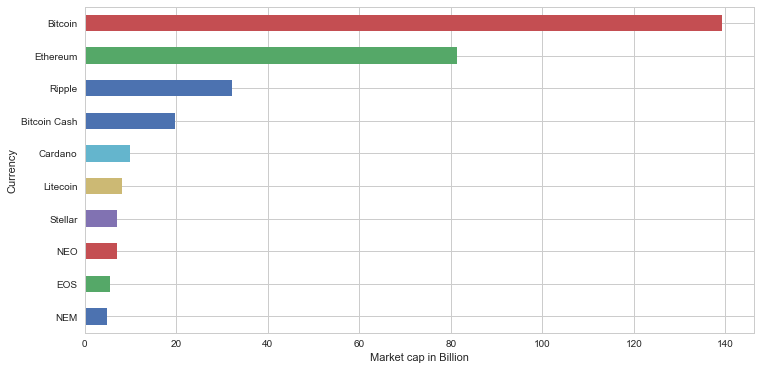

In [481]:
ax = top10Currencies.sort_values().plot(kind='barh')
ax.set_xlabel("Market cap in Billion");
ax.set_ylabel("Currency");


As we can see, and as it was expected, Bitcoin has the highest market cap. Let's see the trend for couple of top currencies.

Text(0,0.5,'Price per 1 unit (in USD)')

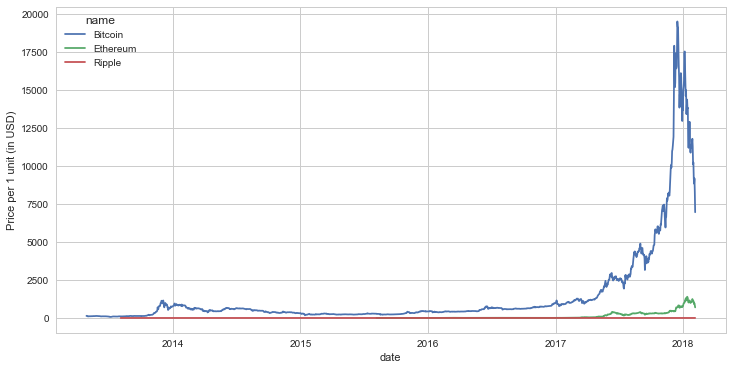

In [482]:
ax = data_top_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

That's rather amusing. Let's see focus on trend starting in 2017th

Text(17.2469,0.5,'Price per 1 unit (in USD)')

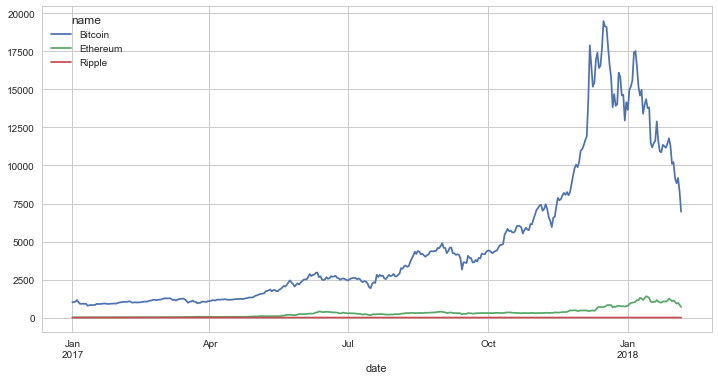

In [483]:
data_top_currencies[data_top_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

We can see that prices have jumped enormously in the 2017th. The cause? Apparently, there are lots of causes. From people's awareness about crypto currencies, to introduction of other currencies that increased the overal need.

Let's see a trend of Trading Volume for top currencies now

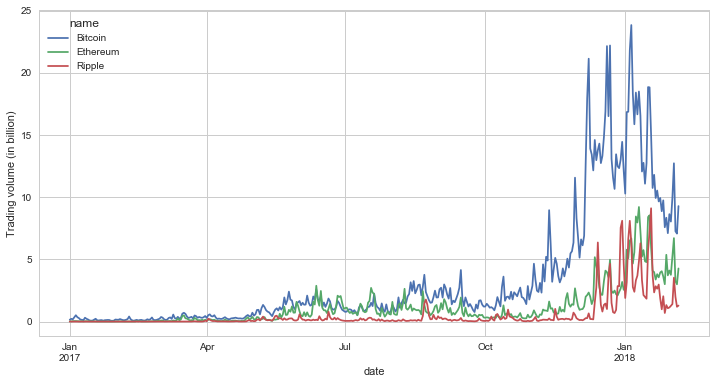

In [484]:
ax = data_top_currencies[data_top_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['volume_billion'].mean().unstack().plot()
ax.set_ylabel("Trading volume (in billion)");

There seems to be a correlation in trading between currencies. Which probably makes sense as, if I understood correctly, most of the currencies are actually traded using Bitcoin (i.e. you have to purchase Bitcoin in order to purchase Ripple). For sake of visibility, I'll plot Bitcoin and other currencies separately. Thing is that Bitcoin prices are actually masking other currencies.

# Experiments

Let's do a small experiment. Let's say that we invested 1000$ in each crypto currency 5 years ago. Let's see how much money would you have now.

First, let's start by drawing a diagram of closing prices for each year for each currency.

In [560]:
def plot_with_textvalue(df):
    ax = df.plot(kind='bar')
    
    ax.set_ylabel("Yearly closing prices (in USD)")

    for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

In [511]:
top10Currencies

name
Bitcoin        139.32
Ethereum        81.34
Ripple          32.22
Bitcoin Cash    19.66
Cardano          9.98
Litecoin         8.19
Stellar          7.06
NEO              6.99
EOS              5.62
NEM              4.94
Name: market_billion, dtype: float64

In [547]:
closing_prices_bitcoin_and_ethereum = data[is_bitcoin | is_etherum].groupby(['date','name'])['close'].last().unstack().reset_index()
closing_prices_other_currencies = data[data['name'].isin(top10Currencies.index) & ~is_bitcoin & ~is_etherum].groupby(['date','name'])['close'].last().unstack().reset_index()

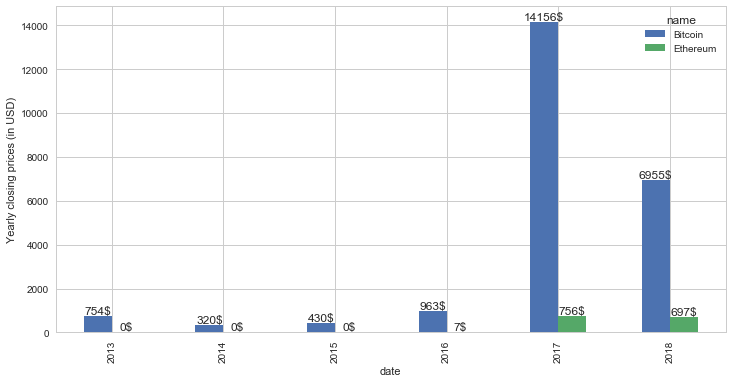

In [561]:
yearly_closing_prices_bitcoin_and_ethereum = closing_prices_bitcoin_and_ethereum.groupby(closing_prices_bitcoin_and_ethereum.date.dt.year).last()
yearly_closing_prices_bitcoin_and_ethereum.drop(columns='date', inplace=True)
plot_with_textvalue(yearly_closing_prices_bitcoin_and_ethereum)

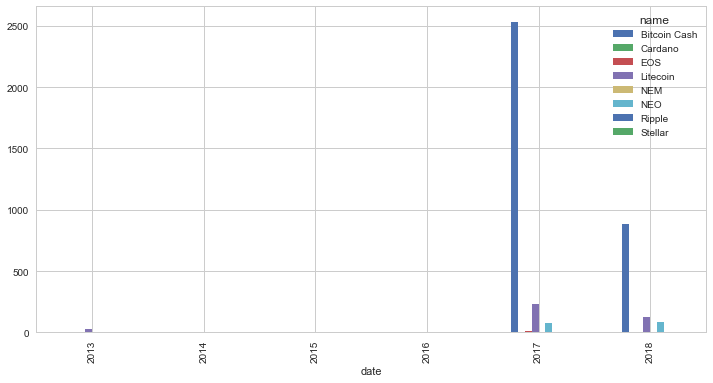

In [563]:
yearly_closing_prices_other_currencies = closing_prices_other_currencies.groupby(closing_prices_other_currencies.date.dt.year).last()
yearly_closing_prices_other_currencies.drop(columns='date', inplace=True)
yearly_closing_prices_other_currencies.plot(kind='bar')

In [537]:
closing_prices_other_currencies.head()

name,date,Bitcoin Cash,Cardano,EOS,Litecoin,NEM,NEO,Ripple,Stellar
0,2013-04-28,nan,nan,nan,4.35,nan,nan,nan,nan
1,2013-04-29,nan,nan,nan,4.38,nan,nan,nan,nan
2,2013-04-30,nan,nan,nan,4.30,nan,nan,nan,nan
3,2013-05-01,nan,nan,nan,3.80,nan,nan,nan,nan
4,2013-05-02,nan,nan,nan,3.37,nan,nan,nan,nan


Let's plot the closing prices, grouped by year.

In [565]:
closing_prices

name,Bitcoin,Ethereum,Ripple
date,,,
2013,754.01,nan,0.03
2014,320.19,nan,0.02
2015,430.57,0.93,0.01
2016,963.74,7.97,0.01
2017,14156.40,756.73,2.30
2018,6955.27,697.95,0.69


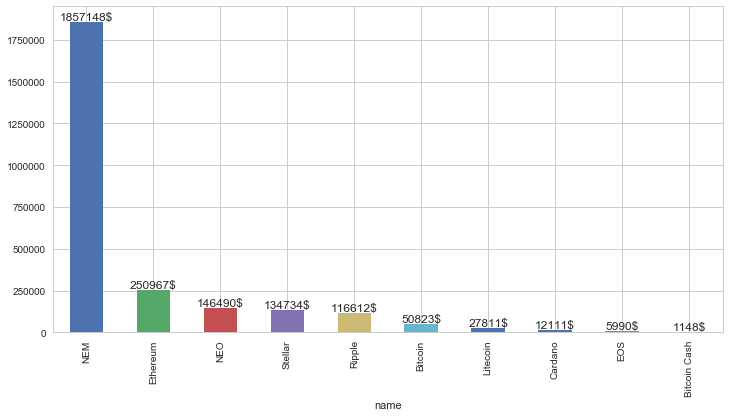

In [642]:
def calc_earnings(currency_name, df):
    #print("Displaying stats for "+currency_name)

    closing_prices = df[(df['name'] == currency_name) & (~df['close'].isnull())][['date', 'close']]

    # Num. currency purchased for 1000$
    #print("Closing price at the beginning: " + str(closing_prices.iloc[0]['close']))

    num_units_purchased = 1000 / closing_prices.iloc[0]['close']
    num_units_purchased

    #print("Num. units purchased: " + str(num_units_purchased))

    # Current value
    last_price = closing_prices.iloc[-1]['close']
    #print("Last price: " + str(last_price))

    amount_earned = (num_units_purchased * last_price) - 1000

    #print("Amount you would have earned: " + str(amount_earned) + "$")
    
    return amount_earned
    
# Borrow the index :-)
top_10_currencies_earnings = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings[currency] = calc_earnings(currency, data)
    
ax = top_10_currencies_earnings.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

Let's try the same, but starting from 2017th ...

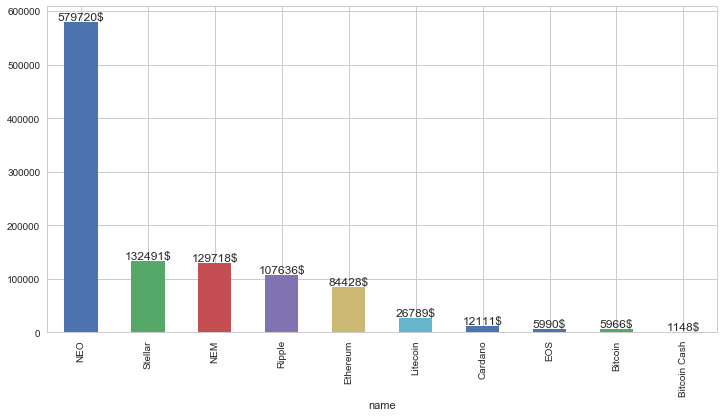

In [644]:
# Borrow the index :-)
top_10_currencies_earnings_2017 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2017[currency] = calc_earnings(currency, data[data.date.dt.year >= 2017])
    
top_10_currencies_earnings_2017

ax = top_10_currencies_earnings_2017.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

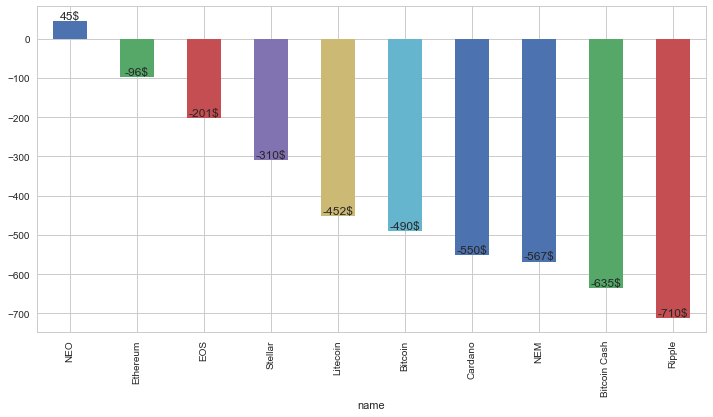

In [645]:
# Borrow the index :-)
top_10_currencies_earnings_2017 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2017[currency] = calc_earnings(currency, data[data.date.dt.year >= 2018])
    
top_10_currencies_earnings_2017

ax = top_10_currencies_earnings_2017.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

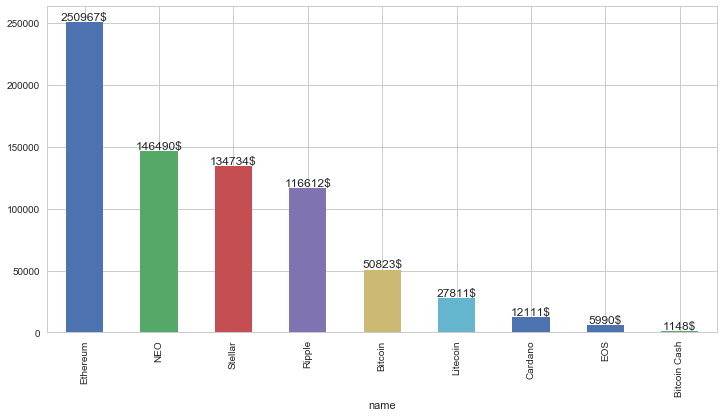

In [633]:
top_10_currencies_earnings_without_nem = top_10_currencies_earnings[top_10_currencies_earnings.index != 'NEM']

ax = top_10_currencies_earnings_without_nem.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

Text(0.5,1,'Correlation Heatmap between Bitcoin and other top 5 Crypto')

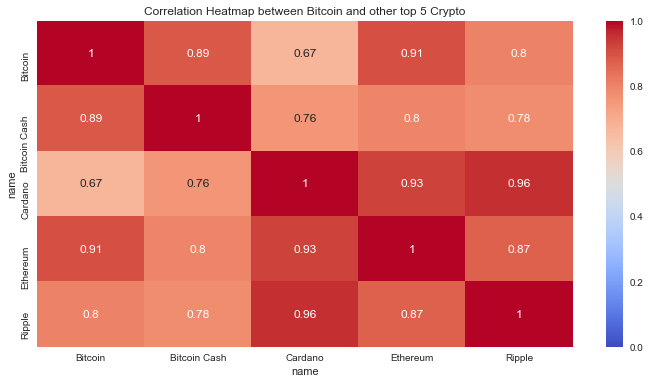

In [669]:
# closing_prices = data.groupby(['date', 'name'])[['name', 'close']].mean().unstack()
# closing_prices.head()

top10Currencies = data.groupby('name')['market_billion'].last().sort_values(ascending=False).head(5)

closing_prices_top10 = data[data['name'].isin(top10Currencies.index)].groupby(['date', 'name'])['close'].mean().unstack()

closing_prices_top10.corr()

plt.figure(figsize=(12,6))
sns.heatmap(closing_prices_top10.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other top 5 Crypto')

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other top 4 Crypto')

# Predictions


Let's start with a simple Regression. Let's see if we can predict the BitCoin values somehow, eh? :-)

Introduce an averga open/close value

In [490]:
data['ohlc_average'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4

In [491]:
X = data[is_bitcoin]

In [492]:
X.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_billion,ohlc_average
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.54,3.88,1.50,0.00,134.40
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.78,13.49,1.49,0.00,140.12
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.38,12.88,1.60,0.00,141.00
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.29,32.17,1.54,0.00,125.90
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.39,33.32,1.29,0.00,109.87


In [493]:
X = data[is_bitcoin].drop(columns=['date','slug', 'symbol', 'name', 'ranknow', 'market_billion', 'close', 'close_ratio', 'ohlc_average', 'volume']).fillna(0)
y = data[is_bitcoin]['close']

In [494]:
X.head()

,open,high,low,market,spread,volume_billion
0,135.30,135.98,132.10,1500520000,3.88,0.00
1,134.44,147.49,134.00,1491160000,13.49,0.00
2,144.00,146.93,134.05,1597780000,12.88,0.00
3,139.00,139.89,107.72,1542820000,32.17,0.00
4,116.38,125.60,92.28,1292190000,33.32,0.00


In [495]:
X['market'] = X['market'] / 1000000 # Decrease the market price as scaler is complaining

In [496]:
# Introduce a new column - avg monthly price. We will use this for prediction

In [497]:
X.head()

,open,high,low,market,spread,volume_billion
0,135.30,135.98,132.10,1500.52,3.88,0.00
1,134.44,147.49,134.00,1491.16,13.49,0.00
2,144.00,146.93,134.05,1597.78,12.88,0.00
3,139.00,139.89,107.72,1542.82,32.17,0.00
4,116.38,125.60,92.28,1292.19,33.32,0.00


In [498]:
X = preprocessing.scale(X)

In [499]:
X_train,X_test,y_train,y_test=cross_validation.train_test_split(X,y,test_size=0.3,random_state=101)

In [500]:
from sklearn.ensemble import RandomForestRegressor

reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 99.7577 %


In [501]:
reg=RandomForestRegressor(n_estimators=10,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 99.8072 %


In [502]:
preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test.iloc[1])


The prediction is: 639.185 But the real value is: 639.89


In [503]:
y_test.iloc[1]

639.88999999999999

In [504]:
X

array([[-0.44499186, -0.44231468, -0.45231823, -0.43810551, -0.3038559 ,
        -0.29246149],
       [-0.44529112, -0.43848985, -0.45161546, -0.43829893, -0.27685927,
        -0.29246149],
       [-0.44196445, -0.43867594, -0.45159697, -0.4360956 , -0.27857289,
        -0.29246149],
       ..., 
       [ 2.58827286,  2.64638553,  2.55091477,  2.61177022,  2.99765597,
         2.38327891],
       [ 2.70087169,  2.61452411,  2.46939002,  2.72476801,  3.34748857,
         2.31320078],
       [ 2.3858956 ,  2.29217812,  1.99796611,  2.41007701,  4.20292523,
         3.12793277]])